In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv
/kaggle/input/crab-age-prediction/CrabAgePrediction.csv


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc
import time

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from category_encoders import OrdinalEncoder, CountEncoder, CatBoostEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, LabelEncoder # OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.decomposition import PCA, NMF

# Import libraries for Hypertuning
import optuna

import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LassoCV
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV, ElasticNetCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.cross_decomposition import PLSRegression
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

!pip install sklego
from sklego.linear_model import LADRegression # Least Absolute Deviation Regression

from sklearn.feature_selection import RFE, RFECV
from sklearn.inspection import permutation_importance

In [88]:
filepath = '/kaggle/input/playground-series-s3e16'

df_train = pd.read_csv(os.path.join(filepath, 'train.csv'), index_col=[0])
df_test = pd.read_csv(os.path.join(filepath, 'test.csv'), index_col=[0])
original = pd.read_csv('/kaggle/input/crab-age-prediction/CrabAgePrediction.csv')

In [89]:
df_train['is_generated'] = 1
df_test['is_generated'] = 1
original['is_generated'] = 0


In [90]:
target_col = 'Age'
num_cols = df_test.select_dtypes(include=['float64']).columns.tolist()
cat_cols = df_test.select_dtypes(include=['object']).columns.tolist()


In [91]:
def cat_encoder(X_train, X_test, cat_cols, encode='label'):
    
    if encode == 'label':
        ## Label Encoder
        encoder = OrdinalEncoder(cols=cat_cols, handle_missing='ignore')
        train_encoder = encoder.fit_transform(X_train[cat_cols]).astype(int)
        test_encoder = encoder.transform(X_test[cat_cols]).astype(int)
        X_train[cat_cols] = train_encoder[cat_cols]
        X_test[cat_cols] = test_encoder[cat_cols]
        encoder_cols = cat_cols
    
    else:
        ## OneHot Encoder
        encoder = OneHotEncoder(cols=cat_cols)
        train_encoder = encoder.fit_transform(X_train[cat_cols]).astype(int)
        test_encoder = encoder.transform(X_test[cat_cols]).astype(int)
        X_train = pd.concat([X_train, train_encoder], axis=1)
        X_test = pd.concat([X_test, test_encoder], axis=1)
        X_train.drop(cat_cols, axis=1, inplace=True)
        X_test.drop(cat_cols, axis=1, inplace=True)
        encoder_cols = list(train_encoder.columns)
        
    return X_train, X_test, encoder_cols

In [92]:
train = pd.concat([df_train, original])
test = df_test.copy()

X_train = train.drop([f'{target_col}'],axis=1).reset_index(drop=True)
y_train = train[f'{target_col}'].reset_index(drop=True)
X_test = test.reset_index(drop=True)

In [93]:
num_cols = X_train.select_dtypes(include=['float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Category Encoders
X_train, X_test, cat_cols = cat_encoder(X_train, X_test, cat_cols, encode='ohe')

In [94]:
sc = StandardScaler() #StandardScaler
X_train[num_cols] = sc.fit_transform(X_train[num_cols])
X_test[num_cols] = sc.transform(X_test[num_cols])

In [95]:
def create_features(df):
    
    # Calculate the Length-to-Diameter Ratio
    df["Length_to_Diameter_Ratio"] = df["Length"] / df["Diameter"]
    
    # Calculate the Length-Minus-Height
    df["Length_Minus_Height"] = df["Length"] - df["Height"]
    
    # Calculate the Weight-to-Shell Weight Ratio
    # df["Weight_to_Shell_Weight_Ratio"] = df["Weight"] / (df["Shell Weight"] + 1e-15)
        
    return df

def add_pca_features(X_train, X_test):    
    
    # Select the columns for PCA
    pca_features = X_train.select_dtypes(include=['float64']).columns.tolist()
    n_components = 4 # len(pca_features)

    # Create the pipeline
    pipeline = make_pipeline(StandardScaler(), PCA(n_components=n_components))
    
    # Perform PCA
    pipeline.fit(X_train[pca_features])

    # Create column names for PCA features
    pca_columns = [f'PCA_{i}' for i in range(n_components)]

    # Add PCA features to the dataframe
    X_train[pca_columns] = pipeline.transform(X_train[pca_features])
    X_test[pca_columns] = pipeline.transform(X_test[pca_features])

    return X_train, X_test

In [96]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5, cat_df=pd.DataFrame(), test_size=0.5):
        self.n_splits = n_splits
        self.kfold = kfold
        self.cat_df = cat_df
        self.test_size = test_size

    def split_data(self, X, y, random_state_list):
        if self.kfold == 'skf':
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, self.cat_df):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val, val_index
        elif self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val, val_index
        else:
            for random_state in random_state_list:
                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
                yield X_train, X_val, y_train, y_val

In [97]:
splitter = Splitter(kfold=False)
for X_train_, X_val, y_train_, y_val in splitter.split_data(X_train, y_train, random_state_list=[42]):
    print('Data set by train_test_split')

Data set by train_test_split


In [141]:
class Regressor:
    def __init__(self, n_estimators=1000, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)
        
    def _define_model(self):
                
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.00482382842096919,
            'booster': 'gbtree',
            'lambda': 0.000235366507474591,
            'alpha': 0.0000115977765684837,
            'subsample': 0.35955930593108,
            'colsample_bytree': 0.898528184386095,
            'max_depth': 9,
            'min_child_weight': 8,
            'eta': 0.0000784943239744148,
            'gamma': 1.6661346939401E-07,
            'grow_policy': 'lossguide',
            'n_jobs': -1,
            'objective': 'reg:squarederror', # reg:pseudohubererror
            'eval_metric': 'mae',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
        
        lgb1_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.00659605502010782,
            "reg_alpha": 0.0134568843414818,
            "reg_lambda": 2.38367559632979E-06,
            "num_leaves": 117,
            "colsample_bytree": 0.850706320762174,
            'subsample': 0.691827302225948,
            'subsample_freq': 4,
            'min_child_samples': 33,
            'objective': 'regression_l2',
            'metric': 'mae',
            'boosting_type': 'gbdt',
            'device': self.device,
            'random_state': self.random_state
        }
        cat1_params = {
            'iterations': self.n_estimators,
            'depth': 7,
            'learning_rate': 0.00454306521731278,
            'l2_leaf_reg': 0.113774158297261,
            'random_strength': 0.0179641854849499,
            'od_type': 'IncToDec',
            'od_wait': 50,
            'bootstrap_type': 'Bayesian',
            'grow_policy': 'Lossguide',
            'bagging_temperature': 1.39240858193441,
            'eval_metric': 'MAE',
            'loss_function': 'MAE',
            'task_type': self.device.upper(),
            'verbose': False,
            'allow_writing_files': False,
            'random_state': self.random_state
        }
        hist_params = {
            'loss': 'absolute_error',
            'l2_regularization': 0.0104104133357932,
            'early_stopping': True,
            'learning_rate': 0.00627298859709192,
            'max_iter': self.n_estimators,
            'n_iter_no_change': 200,
            'max_depth': 16,
            'max_bins': 255,
            'min_samples_leaf': 54,
            'max_leaf_nodes':57,
            'random_state': self.random_state,
            #'categorical_features': []
        }
        gbd_params = {
            'loss': 'absolute_error',
            'n_estimators': 800,
            'max_depth': 10,
            'learning_rate': 0.01,
            'min_samples_split': 10,
            'min_samples_leaf': 20,
            'random_state': self.random_state,
        }
        
        models = {
#             "lad": LADRegression(),
            "xgb": xgb.XGBRegressor(**xgb_params),
            "lgb": lgb.LGBMRegressor(**lgb1_params),
#             "cat": CatBoostRegressor(**cat1_params),
            'hgb': HistGradientBoostingRegressor(**hist_params),
            "SVR_rbf": SVR(kernel="rbf", gamma="auto"),
#             "SVR_linear": SVR(kernel="linear", gamma="auto"),
#             "Ridge": RidgeCV(),
#             "Lasso": LassoCV(),
#             "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5, n_jobs=-1),            
            "RandomForestRegressor": RandomForestRegressor(n_estimators=500, random_state=self.random_state, n_jobs=-1),
#             "SGDRegressor": SGDRegressor(max_iter=2000, early_stopping=True, n_iter_no_change=100, random_state=self.random_state),
            "MLPRegressor": MLPRegressor(max_iter=500, early_stopping=True, n_iter_no_change=10, random_state=self.random_state),
#             "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=self.random_state),
#             "PLSRegression": PLSRegression(n_components=10, max_iter=1000),
            #"PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=1000, tol=1e-3, random_state=self.random_state),
#             "TheilSenRegressor": TheilSenRegressor(max_iter=1000, random_state=self.random_state, n_jobs=-1),
            "GradientBoostingRegressor": GradientBoostingRegressor(**gbd_params),
#             "ARDRegression": ARDRegression(n_iter=1000),
#             "HuberRegressor": HuberRegressor(max_iter=2000)
        }
        
        return models

In [143]:
n_estimators = 500
scoring = 'neg_mean_absolute_error'
min_features_to_select = 6

regressor = Regressor(n_estimators, device='cpu', random_state=0)
models = regressor.models

models_name = [_ for _ in regressor.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)]
trained_models = dict(zip(models_name, ['' for _ in range(regressor.len_models)]))
unnecessary_features = dict(zip(models_name, [[] for _ in range(regressor.len_models)]))
for name, model in models.items():
    if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
        elimination = RFECV(
            model, 
            step=1,
            min_features_to_select=min_features_to_select,
            cv=2,
            scoring=scoring, 
            n_jobs=-1)
        elimination.fit(X_train_, y_train_)
        unnecessary_feature = list(X_train.columns[~elimination.get_support()])
        idx = np.argmax(elimination.cv_results_['mean_test_score'])
        mean_score = elimination.cv_results_['mean_test_score'][idx]
        std_score = elimination.cv_results_['std_test_score'][idx]
        
        
        trained_models[f'{name}'] = deepcopy(elimination)
        unnecessary_features[f'{name}'].extend(unnecessary_feature)
        
unnecessary_features = np.concatenate([_ for _ in unnecessary_features.values()])
features = np.unique(unnecessary_features, return_counts=True)[0]
counts = np.unique(unnecessary_features, return_counts=True)[1]
drop_features = list(features[counts >= 2])


In [144]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=100):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-15, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the score for the weighted prediction
        score = mean_absolute_error(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [145]:
# Settings
kfold = 'skf'
n_splits = 5
n_reapts = 1 # 1
random_state = 42
n_estimators = 99999 # 99999
early_stopping_rounds = 200
n_trials = 3000 # 3000
verbose = False
device = 'cpu'

# Fix seed
random.seed(random_state)
random_state_list = random.sample(range(9999), n_reapts)

# To calculate runtime
def sec_to_minsec(t):
    min_ = int(t / 60)
    sec = int(t - min_*60)
    return min_, sec

# Process
def mattop_post_process(preds, y_true):
    unique_targets = np.unique(y_true)
    return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])

In [151]:
# Initialize an array for storing test predictions
regressor = Regressor(n_estimators, device, random_state)
test_predss = np.zeros((X_test.shape[0]))
post_test_predss = np.zeros((X_test.shape[0]))
oof_predss = np.zeros((X_train.shape[0], n_reapts))
ensemble_score, ensemble_score_ = [], []
weights = []
trained_models = dict(zip([_ for _ in regressor.models_name if ('xgb' in _) or ('lgb' in _) or ('cat' in _)], [[] for _ in range(regressor.len_models)]))
score_dict = dict(zip(regressor.models_name, [[] for _ in range(regressor.len_models)]))

splitter = Splitter(kfold=kfold, n_splits=n_splits, cat_df=y_train)
for i, (X_train_, X_val, y_train_, y_val, val_index) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of regressor models
    regressor = Regressor(n_estimators, device, random_state_list[m])
    models = regressor.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    post_test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        best_iteration = None
        start_time = time.time()
        if ('xgb' in name) or ('lgb' in name) or ('cat' in name):
            early_stopping_rounds_ = int(early_stopping_rounds*2) if ('cat' not in name) else early_stopping_rounds
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds_, verbose=verbose)
            best_iteration = model.best_iteration if ('xgb' in name) else model.best_iteration_
        else:
            model.fit(X_train_, y_train_)
        end_time = time.time()
        min_, sec = sec_to_minsec(end_time - start_time)
            
        if name in trained_models.keys():
            trained_models[f'{name}'].append(deepcopy(model))
        
        y_val_pred = mattop_post_process(model.predict(X_val).reshape(-1), y_val)
        test_pred = model.predict(X_test).reshape(-1)
        post_test_pred = mattop_post_process(model.predict(X_test).reshape(-1), y_train)
        
        score = mean_absolute_error(y_val, y_val_pred)
        score_dict[name].append(score)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] MAE {score:.5f} | Best iteration {best_iteration} | {min_}min {sec}s')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
        post_test_preds.append(post_test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state_list[m], n_trials=n_trials)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    
    score = mean_absolute_error(y_val, y_val_pred)
    
    ensemble_score.append(score)
    weights.append(optweights.weights)
    
    # Predict to X_test by the best ensemble weights
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    post_test_predss += optweights.predict(post_test_preds) / (n_splits * len(random_state_list))
    oof_predss[X_val.index, m] += optweights.predict(oof_preds)
    
    gc.collect()

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-0 SEED-1824] MAE 1.33325 | Best iteration 703 | 1min 27s


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


lgb [FOLD-0 SEED-1824] MAE 1.35904 | Best iteration 1113 | 0min 47s
hgb [FOLD-0 SEED-1824] MAE 1.34447 | Best iteration None | 0min 33s
SVR_rbf [FOLD-0 SEED-1824] MAE 1.34909 | Best iteration None | 2min 14s
RandomForestRegressor [FOLD-0 SEED-1824] MAE 1.43178 | Best iteration None | 2min 32s
MLPRegressor [FOLD-0 SEED-1824] MAE 1.38983 | Best iteration None | 0min 25s
GradientBoostingRegressor [FOLD-0 SEED-1824] MAE 1.33864 | Best iteration None | 4min 13s


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-1 SEED-1824] MAE 1.33646 | Best iteration 711 | 1min 26s


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


lgb [FOLD-1 SEED-1824] MAE 1.36051 | Best iteration 987 | 0min 42s
hgb [FOLD-1 SEED-1824] MAE 1.35980 | Best iteration None | 0min 35s
SVR_rbf [FOLD-1 SEED-1824] MAE 1.35974 | Best iteration None | 2min 12s
RandomForestRegressor [FOLD-1 SEED-1824] MAE 1.42581 | Best iteration None | 2min 30s
MLPRegressor [FOLD-1 SEED-1824] MAE 1.39733 | Best iteration None | 0min 29s
GradientBoostingRegressor [FOLD-1 SEED-1824] MAE 1.34524 | Best iteration None | 4min 13s


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-2 SEED-1824] MAE 1.33492 | Best iteration 706 | 1min 27s


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


lgb [FOLD-2 SEED-1824] MAE 1.35904 | Best iteration 819 | 0min 35s
hgb [FOLD-2 SEED-1824] MAE 1.34961 | Best iteration None | 0min 23s
SVR_rbf [FOLD-2 SEED-1824] MAE 1.34858 | Best iteration None | 2min 13s
RandomForestRegressor [FOLD-2 SEED-1824] MAE 1.42395 | Best iteration None | 2min 29s
MLPRegressor [FOLD-2 SEED-1824] MAE 1.39368 | Best iteration None | 0min 24s
GradientBoostingRegressor [FOLD-2 SEED-1824] MAE 1.34133 | Best iteration None | 4min 13s


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-3 SEED-1824] MAE 1.34832 | Best iteration 711 | 1min 26s


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


lgb [FOLD-3 SEED-1824] MAE 1.37738 | Best iteration 1108 | 1min 0s
hgb [FOLD-3 SEED-1824] MAE 1.36083 | Best iteration None | 0min 48s
SVR_rbf [FOLD-3 SEED-1824] MAE 1.37097 | Best iteration None | 2min 13s
RandomForestRegressor [FOLD-3 SEED-1824] MAE 1.44179 | Best iteration None | 2min 27s
MLPRegressor [FOLD-3 SEED-1824] MAE 1.41209 | Best iteration None | 0min 28s
GradientBoostingRegressor [FOLD-3 SEED-1824] MAE 1.35916 | Best iteration None | 4min 16s


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


xgb [FOLD-4 SEED-1824] MAE 1.35290 | Best iteration 686 | 1min 25s


/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


lgb [FOLD-4 SEED-1824] MAE 1.38786 | Best iteration 859 | 0min 43s
hgb [FOLD-4 SEED-1824] MAE 1.36297 | Best iteration None | 0min 25s
SVR_rbf [FOLD-4 SEED-1824] MAE 1.37061 | Best iteration None | 2min 12s
RandomForestRegressor [FOLD-4 SEED-1824] MAE 1.45631 | Best iteration None | 2min 28s
MLPRegressor [FOLD-4 SEED-1824] MAE 1.40923 | Best iteration None | 0min 35s
GradientBoostingRegressor [FOLD-4 SEED-1824] MAE 1.35726 | Best iteration None | 4min 12s


--- Mean MAE Scores---


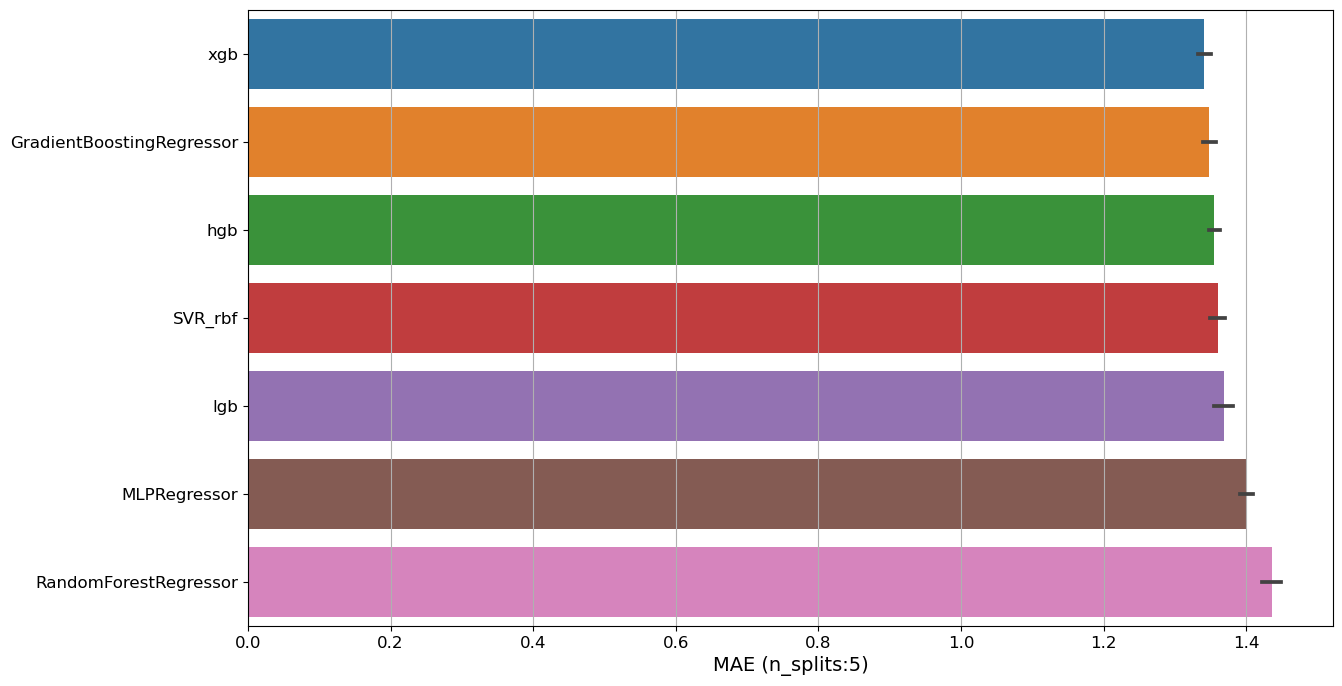

In [152]:
def plot_score_from_dict(score_dict, title='MAE', ascending=True):
    score_df = pd.melt(pd.DataFrame(score_dict))
    score_df = score_df.sort_values('value', ascending=ascending)
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='value', y='variable', data=score_df,errorbar='sd')
    plt.xlabel(f'{title}', fontsize=14)
    plt.ylabel('')
    #plt.title(f'{title}', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='x')
    plt.show()

print('--- Mean MAE Scores---')    
for name, score in score_dict.items():
    mean_score = np.mean(score)
    std_score = np.std(score)
    
plot_score_from_dict(score_dict, title=f'MAE (n_splits:{n_splits})')

In [153]:
unique_targets = np.unique(y_train)
def mattop_post_process(preds):
     return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])

In [154]:
def make_submission(test_predss, prefix=''):
    # No post-processing during training
    subs = pd.DataFrame()

    sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))
    sub[f'{target_col}'] = test_predss
    sub.to_csv(f'{prefix}submission.csv', index=False)

    subs = pd.concat([subs, sub], axis=1)

    sub = pd.read_csv(os.path.join(filepath, 'sample_submission.csv'))
    sub[f'{target_col}'] = mattop_post_process(test_predss)
    sub.to_csv(f'{prefix}submission_mattop.csv', index=False)

    display(pd.merge(subs, sub, on='id', suffixes=("", "_mattop")))
    
make_submission(test_predss, prefix='') 
make_submission(post_test_predss, prefix='post_') 

,id,Age,Age_mattop
0,74051,7.365189,7
1,74052,7.598302,8
2,74053,10.472154,10
3,74054,9.549535,10
4,74055,7.211220,7
...,...,...,...
49363,123414,9.108520,9
49364,123415,8.198112,8
49365,123416,12.637489,13
49366,123417,9.609869,10


,id,Age,Age_mattop
0,74051,7.033156,7
1,74052,7.837243,8
2,74053,10.493921,10
3,74054,9.761685,10
4,74055,7.020489,7
...,...,...,...
49363,123414,8.991042,9
49364,123415,8.001620,8
49365,123416,12.789352,13
49366,123417,9.869202,10
